In [2]:
%ls
# %pip install -r requirements.txt -q
%pip install tensorflow keras -q

examples/  README.md         setup.py  tensorflow_engram/
LICENSE    requirements.txt  setup.sh


In [ ]:
import os, sys
# sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath(''))))
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.datasets import mnist
from IPython.display import Image
from time import perf_counter as perf_time
from keras.utils import to_categorical, plot_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow_engram.layers import Engram
from tensorflow_engram.models import EngramClassifier
from tensorflow_engram.utils import HebbianTraceMonitor, plot_hebbian_trace

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

np.random.seed(42)
tf.random.set_seed(42)

In [4]:
%pip install datasets --upgrade -q
from datasets import load_dataset

In [5]:
dataset = load_dataset("wikitext", "wikitext-103-v1", split="train")

# Shuffle and take quarter due to colab constraints
dataset = dataset.shuffle(seed=42).select(np.arange(len(dataset) // 4))

# Preprocess the dataset
def preprocess_text(text):
    tokens = text.split()
    tokens = [token.lower() for token in tokens]
    return tokens
dataset = dataset.map(lambda x: {'tokens': preprocess_text(x['text'])})

# Create a vocabulary
vocab = set()
for example in dataset:
    vocab.update(example['tokens'])
vocab = sorted(vocab)
vocab_size = len(vocab)
word_to_index = {word: i for i, word in enumerate(vocab)}
index_to_word = {i: word for i, word in enumerate(vocab)}

# Convert tokens to indices
def tokens_to_indices(tokens):
    return [word_to_index[token] for token in tokens if token in word_to_index]
dataset = dataset.map(lambda x: {'indices': tokens_to_indices(x['tokens'])})

# Create sequences
def create_sequences(indices, seq_length=32):
    sequences = []
    for i in range(0, len(indices) - seq_length, seq_length):
        sequences.append(indices[i:i + seq_length])
    return sequences
dataset = dataset.map(lambda x: {'sequences': create_sequences(x['indices'])})

# Convert the dataset to a list of dictionaries before splitting
dataset_list = [example for example in dataset]

# Split the dataset into train and test sets before flattening
train_dataset, test_dataset = train_test_split(dataset_list, test_size=0.2, random_state=42)

# Flatten the sequences within each split
train_dataset = [item for sublist in train_dataset for item in sublist['sequences']]
test_dataset = [item for sublist in test_dataset for item in sublist['sequences']]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/722k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/156M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/655k [00:00<?, ?B/s]

Generating test split:   0%|          | 0/4358 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/1801350 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3760 [00:00<?, ? examples/s]

Map:   0%|          | 0/450337 [00:00<?, ? examples/s]

Map:   0%|          | 0/450337 [00:00<?, ? examples/s]

Map:   0%|          | 0/450337 [00:00<?, ? examples/s]

In [6]:
print(vocab_size)
print("Dataset lengths:", len(train_dataset), len(test_dataset))

188590
Dataset lengths: 536711 133990


In [7]:
from keras.preprocessing.sequence import pad_sequences

# Use the already split datasets (these are lists of token-index sequences)
X_train = train_dataset
X_test = test_dataset

# Pad sequences to ensure uniform length
max_sequence_length = 32
X_train = pad_sequences(X_train, maxlen=max_sequence_length, padding='post', truncating='post')
X_test = pad_sequences(X_test, maxlen=max_sequence_length, padding='post', truncating='post')

# OLD: Ensure type is integer (not float!)
# X_train = np.array(X_train, dtype=np.int32)
# X_test = np.array(X_test, dtype=np.int32)

X_train = np.array(X_train, dtype=np.float32)
X_test = np.array(X_test, dtype=np.float32)

# Prepare next-token prediction targets (predict x_{t+1} given x_t)
y_train = np.roll(X_train, shift=-1, axis=1)
y_test = np.roll(X_test, shift=-1, axis=1)

# Optionally, mask out the last label (since it's wrapped around by np.roll)
# We can use 0, -100, or a vocab PAD token; ensure loss function ignores it if needed.
y_train[:, -1] = 0  # Use PAD token or 0
y_test[:, -1] = 0

# Reshape inputs for the model: (num_samples, seq_length, 1) -- for one-hot input
X_train = X_train[..., np.newaxis]  # shape: (num_samples, seq_length, 1)
X_test = X_test[..., np.newaxis]

# Targets remain as (num_samples, seq_length) of integer class indices
# No flattening needed unless the model expects it (sequence-to-sequence is standard)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ engram (Engram)                 │ (None, 32, 128)        │       214,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 32, 188590)     │    24,328,110 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,542,382 (93.62 MB)

 Trainable params: 24,534,190 (93.59 MB)

 Non-trainable params: 8,192 (32.00 KB)

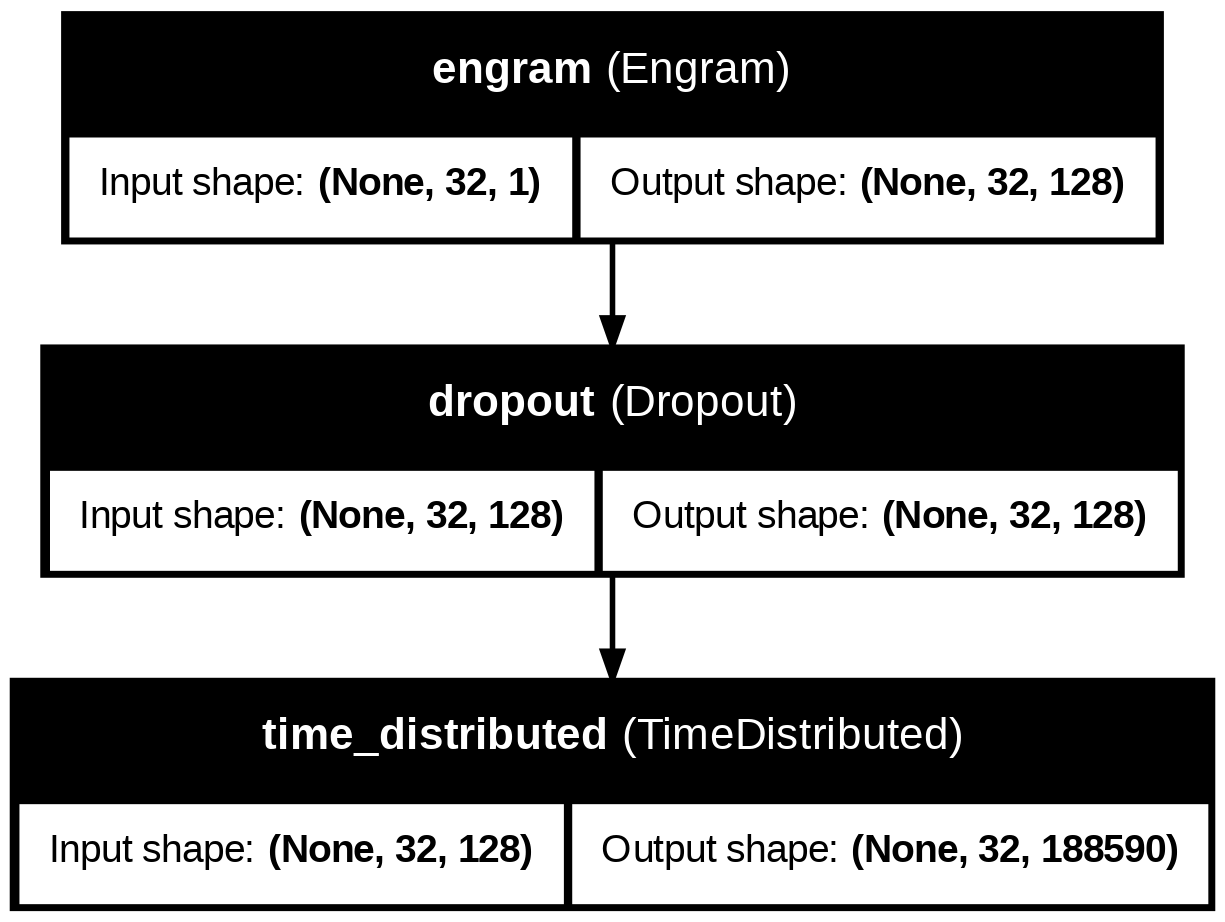

In [9]:
# Create the model
model = EngramClassifier(
    input_shape=(32, 1),
    hidden_dim=128,
    memory_size=64,
    num_classes=vocab_size,
    return_states=True,
    return_sequences=True,
    use_attention=False,
    sparsity_strength=0.3,
    hebbian_lr=0.05  # Higher learning rate for Hebbian updates
)

trace_callback = HebbianTraceMonitor(
    X_train[:32],
    log_dir="examples/out/wikitext_hebbian_trace",
    verbose=1,
    plot_every=100,
    skip_first_plot=True
)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)
lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_perplexity',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    mode='min'
)

# Define perplexity metric
def perplexity(y_true, y_pred):
    # Flatten the targets and predictions to (num_samples * seq_length, ...) for the metric
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1, vocab_size])
    cross_entropy = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    return tf.exp(tf.reduce_mean(cross_entropy))

# Compile and train the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', perplexity]
)
model.summary()
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_model.png')
#Image(filename='examples/out/wikitext_model.png', width=800)

In [10]:
# Train the model
start_time = perf_time()
history = model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[trace_callback, early_stopping, lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

HebbianTraceMonitor initialized.
Epoch 1/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.0756 - loss: 7.3949 - perplexity: 4328.5249
Hebbian trace [Epoch 1] - min: -0.1000, max: 0.1000, mean abs: 0.0092, sparsity: 74.07%
Saved Hebbian trace visualization to examples/out/wikitext_hebbian_trace/hebbian_trace_epoch1_20250727-192702.png
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 427s 122ms/step - accuracy: 0.0756 - loss: 7.3948 - perplexity: 4327.7617 - val_accuracy: 0.0898 - val_loss: 7.1332 - val_perplexity: 1255.1505 - learning_rate: 0.0010
Epoch 2/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.0883 - loss: 7.1545 - perplexity: 1281.7009
Hebbian trace [Epoch 2] - min: -0.1000, max: 0.1000, mean abs: 0.0090, sparsity: 78.00%
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 385s 115ms/step - accuracy: 0.0883 - loss: 7.1545 - perplexity: 1281.7012 - val_accuracy: 0.0892 - val_loss: 7.1243 - val_perplexity: 1244.3860 - learning_rate: 0.0010
Epoch 3/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/st

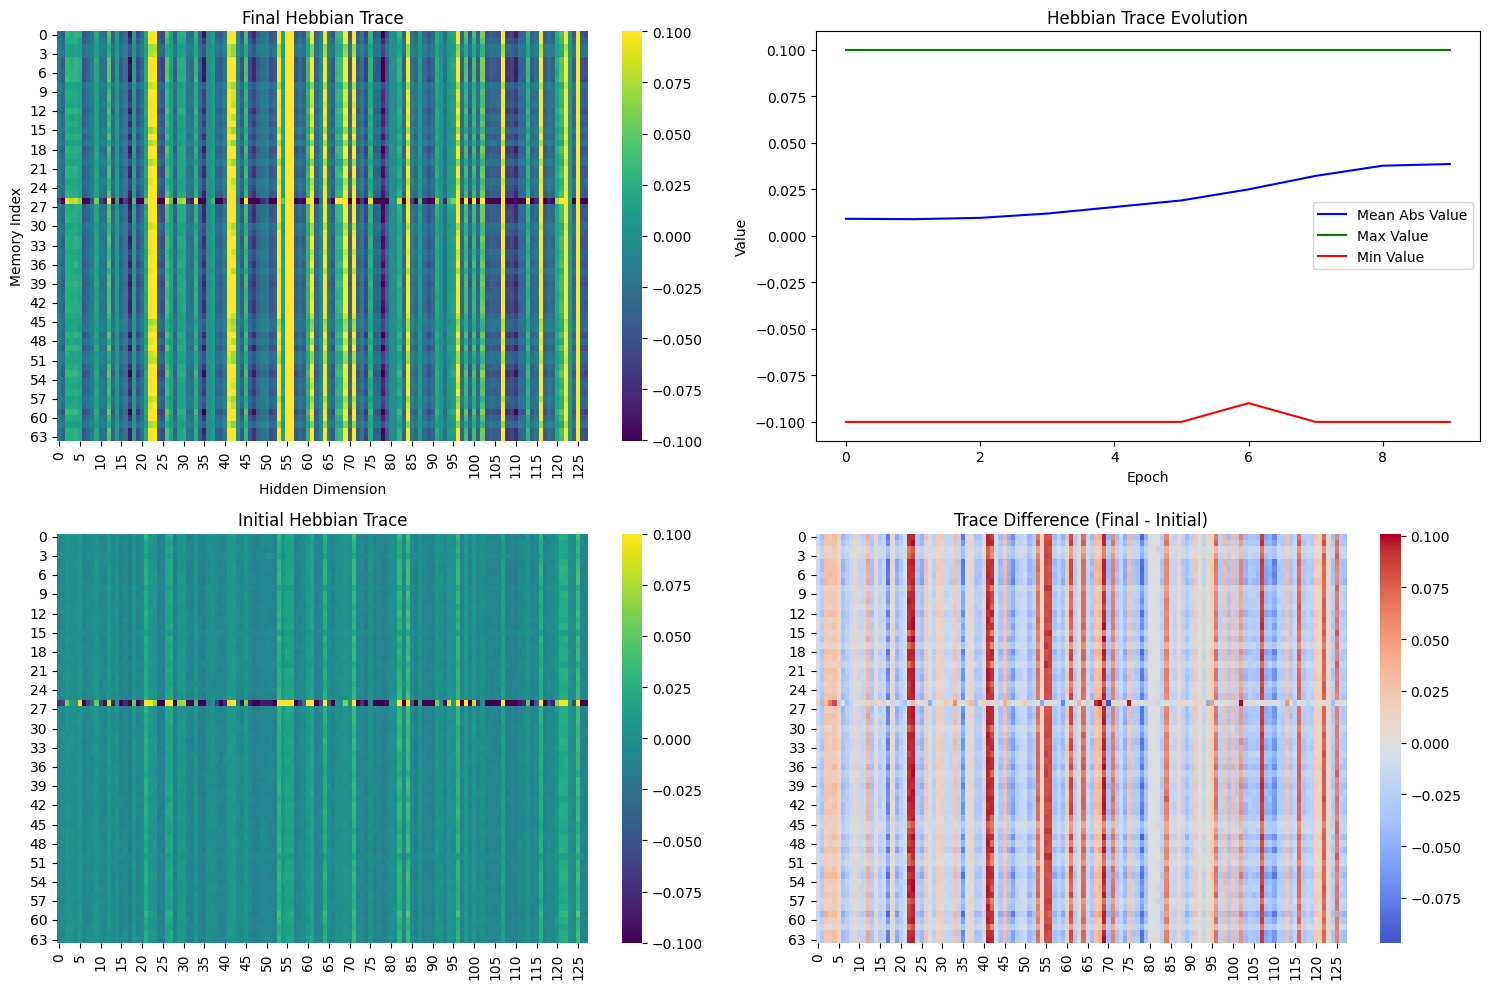

In [11]:
plot_hebbian_trace(trace_callback)  #, file_path='examples/out/hebbian_trace.png')

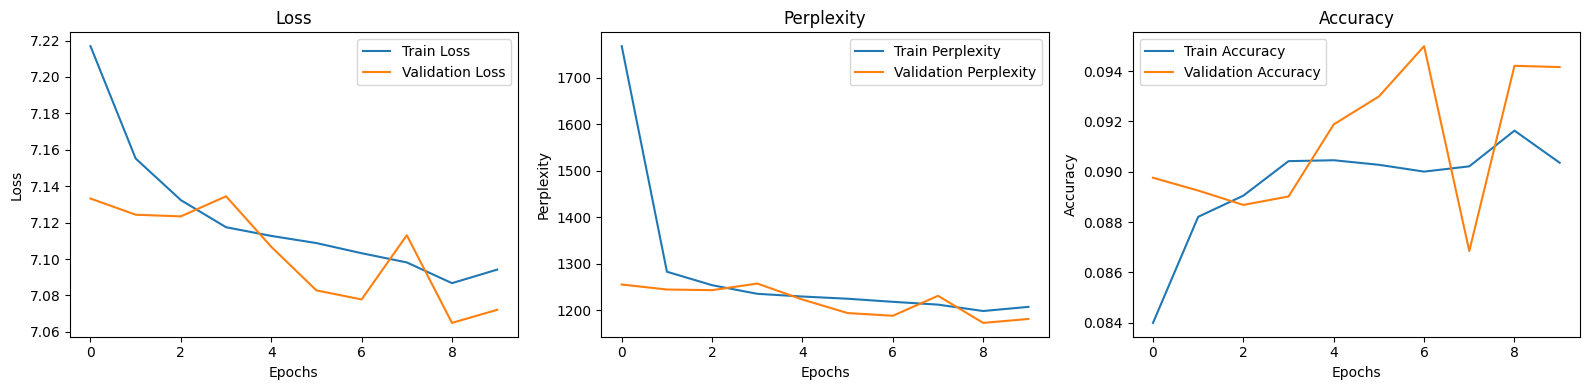

In [12]:
# Plot the training history
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(history.history['perplexity'], label='Train Perplexity')
plt.plot(history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_training_history.png')
plt.show()


In [13]:
enn_evaluation = model.evaluate(X_test, y_test)
print(f"Test Loss: {enn_evaluation[0]:.4f}")
print(f"Test Accuracy: {enn_evaluation[1]:.4f}")
print(f"Test Perplexity: {enn_evaluation[2]:.4f}")

4188/4188 ━━━━━━━━━━━━━━━━━━━━ 94s 21ms/step - accuracy: 0.0942 - loss: 7.0681 - perplexity: 1183.4321
Test Loss: 7.0656
Test Accuracy: 0.0942
Test Perplexity: 1180.8069


## RNN Benchmark

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 32, 128)        │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_1              │ (None, 32, 188590)     │    24,328,110 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,377,646 (92.99 MB)

 Trainable params: 24,377,646 (92.99 MB)

 Non-trainable params: 0 (0.00 B)

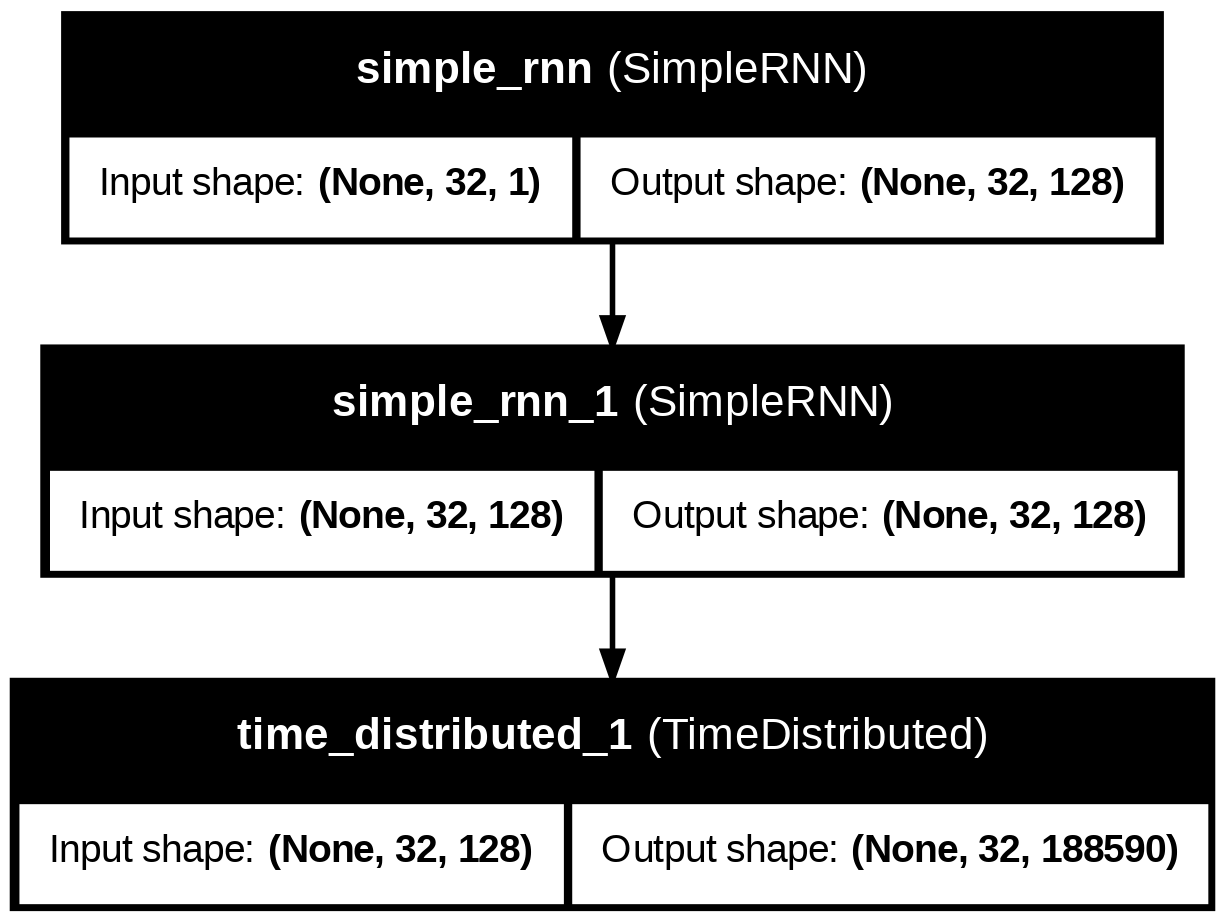

In [14]:
# Create an RNN model that is comparable to the ENN
rnn_model = keras.Sequential([
    keras.layers.SimpleRNN(128, input_shape=(32, 1), return_sequences=True),
    keras.layers.SimpleRNN(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax'))
])

rnn_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)
rnn_lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_perplexity',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    mode='min'
)

rnn_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', perplexity]
)
rnn_model.summary()
plot_model(rnn_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_rnn_model.png')
#Image(filename='examples/out/wikitext_rnn_model.png', width=800)

In [15]:
# Train the model
start_time = perf_time()
rnn_history = rnn_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[rnn_early_stopping, rnn_lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 388s 113ms/step - accuracy: 0.0605 - loss: 7.4384 - perplexity: 4405.2466 - val_accuracy: 0.0649 - val_loss: 7.1577 - val_perplexity: 1286.5924 - learning_rate: 0.0010
Epoch 2/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 365s 109ms/step - accuracy: 0.0719 - loss: 7.1219 - perplexity: 1240.8130 - val_accuracy: 0.0987 - val_loss: 7.0168 - val_perplexity: 1117.5096 - learning_rate: 0.0010
Epoch 3/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 365s 109ms/step - accuracy: 0.0972 - loss: 7.0107 - perplexity: 1109.8345 - val_accuracy: 0.0977 - val_loss: 7.0134 - val_perplexity: 1113.6890 - learning_rate: 0.0010
Epoch 4/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 365s 109ms/step - accuracy: 0.0990 - loss: 6.9843 - perplexity: 1081.0374 - val_accuracy: 0.1025 - val_loss: 6.9648 - val_perplexity: 1061.0181 - learning_rate: 0.0010
Epoch 5/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 365s 109ms/step - accuracy: 0.1027 - loss: 6.9372 - perplexity: 1031.1663 - val_accuracy: 0.1029 - val_loss: 6.9627 - 

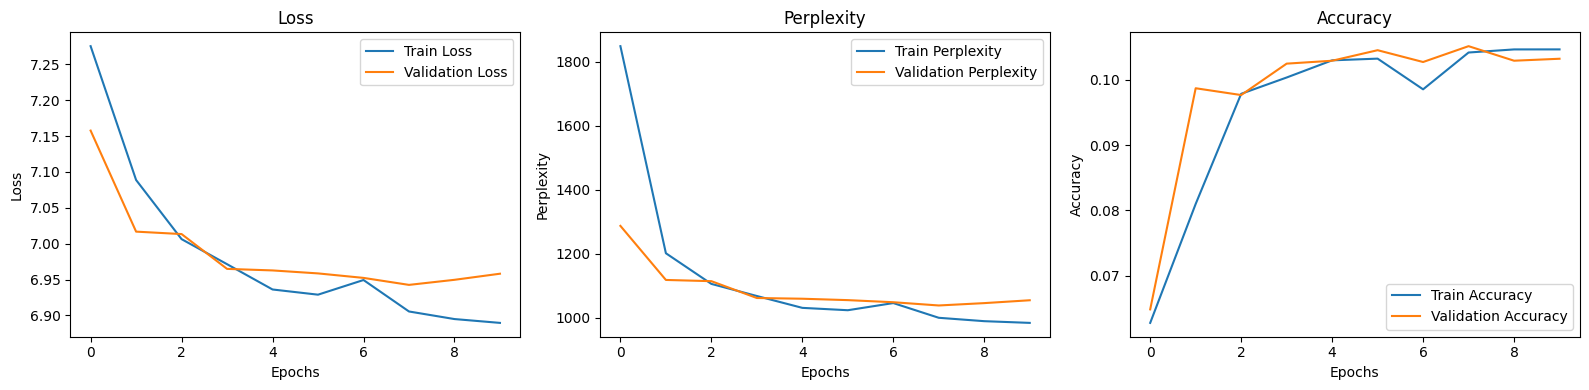

In [16]:
# Plot the training history
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(rnn_history.history['loss'], label='Train Loss')
plt.plot(rnn_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(rnn_history.history['perplexity'], label='Train Perplexity')
plt.plot(rnn_history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(rnn_history.history['accuracy'], label='Train Accuracy')
plt.plot(rnn_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_rnn_training_history.png')
plt.show()

In [17]:
rnn_evaluation = rnn_model.evaluate(X_test, y_test)
print(f"Test Loss: {rnn_evaluation[0]:.4f}")
print(f"Test Accuracy: {rnn_evaluation[1]:.4f}")
print(f"Test Perplexity: {rnn_evaluation[2]:.4f}")

4188/4188 ━━━━━━━━━━━━━━━━━━━━ 87s 20ms/step - accuracy: 0.1052 - loss: 6.9462 - perplexity: 1048.8751
Test Loss: 6.9440
Test Accuracy: 0.1053
Test Perplexity: 1046.9852


## GRU Benchmark

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 32, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 32, 188590)     │    24,328,110 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,477,486 (93.37 MB)

 Trainable params: 24,477,486 (93.37 MB)

 Non-trainable params: 0 (0.00 B)

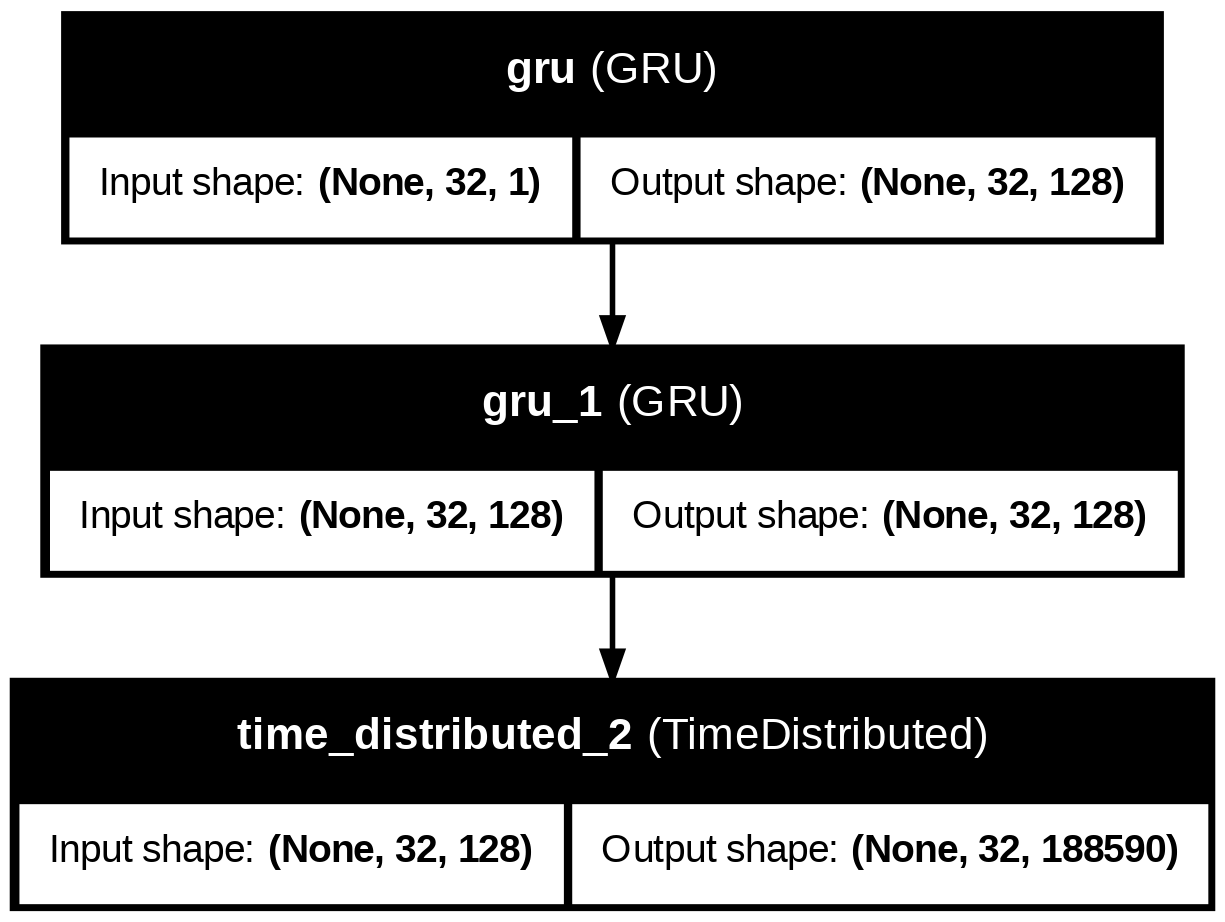

In [18]:
# Create a GRU model that is comparable to the ENN
gru_model = keras.Sequential([
    keras.layers.GRU(128, input_shape=(32, 1), return_sequences=True),
    keras.layers.GRU(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax'))
])

gru_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

gru_lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_perplexity',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    mode='min'
)

gru_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', perplexity]
)

gru_model.summary()
plot_model(gru_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_gru_model.png')
# Image(filename='examples/out/wikitext_gru_model.png', width=800)

In [19]:
# Train the model
start_time = perf_time()
gru_history = gru_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[gru_early_stopping, gru_lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1093s 324ms/step - accuracy: 0.0719 - loss: 7.4068 - perplexity: 4644.6875 - val_accuracy: 0.0964 - val_loss: 7.1068 - val_perplexity: 1222.6406 - learning_rate: 0.0010
Epoch 2/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1088s 324ms/step - accuracy: 0.0953 - loss: 7.0934 - perplexity: 1205.6029 - val_accuracy: 0.0958 - val_loss: 7.0522 - val_perplexity: 1157.9158 - learning_rate: 0.0010
Epoch 3/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1087s 324ms/step - accuracy: 0.0958 - loss: 7.0294 - perplexity: 1130.7363 - val_accuracy: 0.0964 - val_loss: 7.0041 - val_perplexity: 1103.5304 - learning_rate: 0.0010
Epoch 4/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1088s 324ms/step - accuracy: 0.0973 - loss: 6.9928 - perplexity: 1090.2788 - val_accuracy: 0.0975 - val_loss: 6.9894 - val_perplexity: 1087.5011 - learning_rate: 0.0010
Epoch 5/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1088s 324ms/step - accuracy: 0.0992 - loss: 6.9668 - perplexity: 1062.3485 - val_accuracy: 0.1013 - val_loss: 6.96

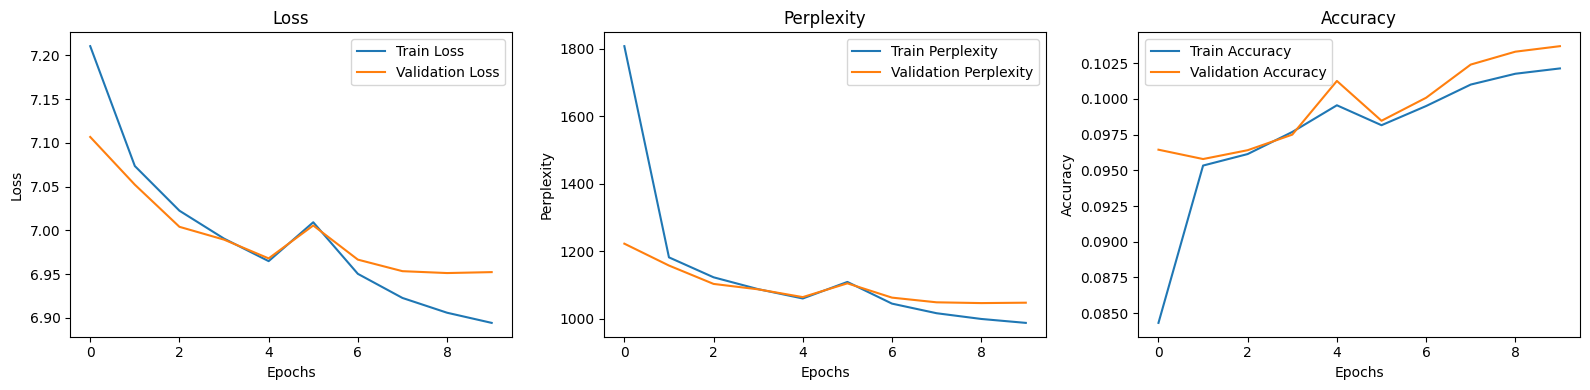

In [20]:
# Plot the training history
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(gru_history.history['loss'], label='Train Loss')
plt.plot(gru_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(gru_history.history['perplexity'], label='Train Perplexity')
plt.plot(gru_history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(gru_history.history['accuracy'], label='Train Accuracy')
plt.plot(gru_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_gru_training_history.png')
plt.show()

In [21]:
gru_evaluation = gru_model.evaluate(X_test, y_test)
print(f"Test Loss: {gru_evaluation[0]:.4f}")
print(f"Test Accuracy: {gru_evaluation[1]:.4f}")
print(f"Test Perplexity: {gru_evaluation[2]:.4f}")

4188/4188 ━━━━━━━━━━━━━━━━━━━━ 422s 101ms/step - accuracy: 0.1032 - loss: 6.9542 - perplexity: 1057.1321
Test Loss: 6.9520
Test Accuracy: 0.1033
Test Perplexity: 1055.2123


## LSTM Benchmark

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 32, 188590)     │    24,328,110 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,526,254 (93.56 MB)

 Trainable params: 24,526,254 (93.56 MB)

 Non-trainable params: 0 (0.00 B)

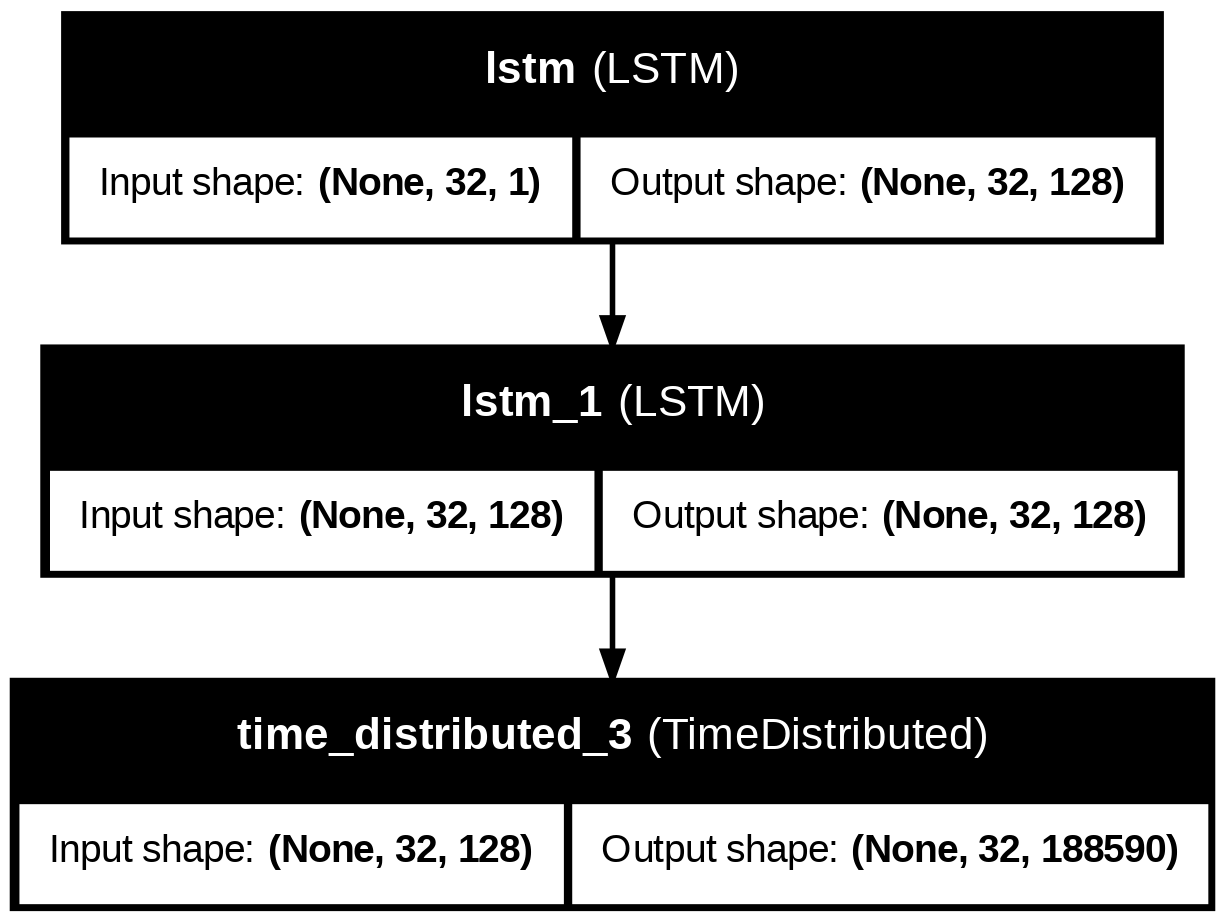

In [22]:
# Create an LSTM model that is comparable to the ENN
lstm_model = keras.Sequential([
    keras.layers.LSTM(128, input_shape=(32, 1), return_sequences=True),
    keras.layers.LSTM(128, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(vocab_size, activation='softmax'))
])

lstm_early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_perplexity',
    patience=3,
    restore_best_weights=True,
    mode='min'
)

lstm_lr_scheduler = keras.callbacks.ReduceLROnPlateau(
    monitor='val_perplexity',
    factor=0.5,
    patience=2,
    min_lr=1e-5,
    mode='min'
)

lstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001, clipnorm=1.0),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', perplexity]
)

lstm_model.summary()
plot_model(lstm_model, show_shapes=True, show_layer_names=True, expand_nested=True, to_file='examples/out/wikitext_lstm_model.png')

In [23]:
# Train the model
start_time = perf_time()
lstm_history = lstm_model.fit(
    X_train,
    y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[lstm_early_stopping, lstm_lr_scheduler]
)
end_time = perf_time()
print(f"Training time: {end_time - start_time:.2f} seconds")

Epoch 1/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1091s 324ms/step - accuracy: 0.0611 - loss: 7.4520 - perplexity: 5432.0654 - val_accuracy: 0.0753 - val_loss: 7.1563 - val_perplexity: 1284.6108 - learning_rate: 0.0010
Epoch 2/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1088s 324ms/step - accuracy: 0.0863 - loss: 7.1088 - perplexity: 1224.4927 - val_accuracy: 0.0936 - val_loss: 7.0381 - val_perplexity: 1141.4857 - learning_rate: 0.0010
Epoch 3/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1089s 325ms/step - accuracy: 0.0989 - loss: 7.0154 - perplexity: 1115.1179 - val_accuracy: 0.1041 - val_loss: 6.9596 - val_perplexity: 1055.4492 - learning_rate: 0.0010
Epoch 4/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1089s 325ms/step - accuracy: 0.1049 - loss: 6.9351 - perplexity: 1028.9437 - val_accuracy: 0.1048 - val_loss: 6.9140 - val_perplexity: 1008.6087 - learning_rate: 0.0010
Epoch 5/10
3355/3355 ━━━━━━━━━━━━━━━━━━━━ 1089s 324ms/step - accuracy: 0.1074 - loss: 6.9032 - perplexity: 996.8373 - val_accuracy: 0.1079 - val_loss: 6.898

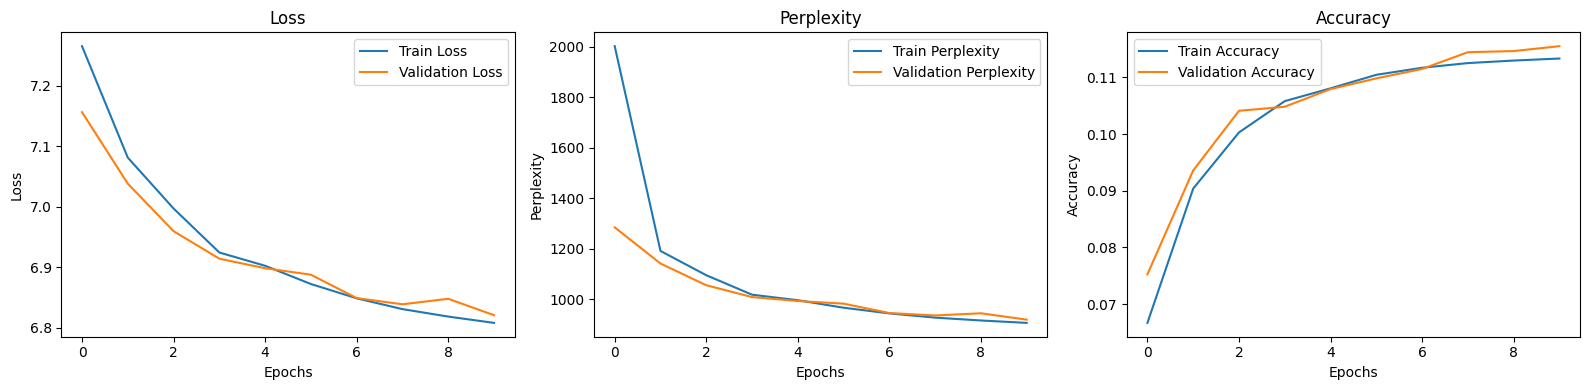

In [24]:
# Plot the training history
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(lstm_history.history['loss'], label='Train Loss')
plt.plot(lstm_history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(lstm_history.history['perplexity'], label='Train Perplexity')
plt.plot(lstm_history.history['val_perplexity'], label='Validation Perplexity')
plt.title('Perplexity')
plt.xlabel('Epochs')
plt.ylabel('Perplexity')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(lstm_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('examples/out/wikitext_lstm_training_history.png')
plt.show()

In [25]:
lstm_evaluation = lstm_model.evaluate(X_test, y_test)
print(f"Test Loss: {lstm_evaluation[0]:.4f}")
print(f"Test Accuracy: {lstm_evaluation[1]:.4f}")
print(f"Test Perplexity: {lstm_evaluation[2]:.4f}")

4188/4188 ━━━━━━━━━━━━━━━━━━━━ 425s 101ms/step - accuracy: 0.1154 - loss: 6.8253 - perplexity: 931.2651
Test Loss: 6.8233
Test Accuracy: 0.1155
Test Perplexity: 929.5464


## Architecture Comparison

In [26]:
# Compare results across all 4 architectures -- ENN, RNN, GRU, LSTM
# y_test = y_test.reshape(-1, 32)[:, 0]
results = {
    'ENN': enn_evaluation,
    'RNN': rnn_evaluation,
    'GRU': gru_evaluation,
    'LSTM': lstm_evaluation
}

# Create a DataFrame to display the results
results_df = pd.DataFrame(results, index=['Loss', 'Accuracy', 'Perplexity'])
results_df.T
results_df

,ENN,RNN,GRU,LSTM
Loss,7.065606,6.944032,6.952037,6.823267
Accuracy,0.094152,0.105323,0.103294,0.115464
Perplexity,1180.806885,1046.985229,1055.212280,929.546448
